##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gradient Boosted Trees: Model understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/estimator/boosted_trees_model_understanding.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/estimator/boosted_trees_model_understanding.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


For an end-to-end walkthrough of training a Gradient Boosting model check out the [boosted trees tutorial](./boosted_trees). In this tutorial you will:

* Learn how to interpret a Boosted Trees model both *locally* and *globally*
* Gain intution for how a Boosted Trees model fits a dataset

## How to interpret Boosted Trees models both locally and globally

Local interpretability refers to an understanding of a model’s predictions at the individual example level, while global interpretability refers to an understanding of the model as a whole. Such techniques can help machine learning (ML) practitioners detect bias and bugs during the model development stage.

For local interpretability, you will learn how to create and visualize per-instance contributions. To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

For global interpretability you will retrieve and visualize gain-based feature importances, [permutation feature importances](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) and also show aggregated DFCs.

## Load the titanic dataset
You will be using the titanic dataset, where the (rather morbid) goal is to predict passenger survival, given characteristics such as gender, age, class, etc.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [3]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.random.set_seed(123)

For a description of the features, please review the prior tutorial.

## Create feature columns, input_fn, and the train the estimator

### Preprocess the data

Create the feature columns, using the original numeric columns as is and one-hot-encoding categorical variables.

In [4]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

### Build the input pipeline

Create the input functions using the `from_tensor_slices` method in the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API to read in data directly from Pandas.

In [5]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

### Train the model

In [6]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.862504
auc_precision_recall,0.836979
average_loss,0.424678
label/mean,0.375000
loss,0.424678
precision,0.752688
prediction/mean,0.387535
recall,0.707071


For performance reasons, when your data fits in memory, we recommend use the `boosted_trees_classifier_train_in_memory` function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the `tf.estimator.BoostedTrees` API shown above.


When using this method, you should not batch your input data, as the method operates on the entire dataset.


In [7]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'G:\\TMP\\tmp3dla083l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F0D2F07048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflo

## Model interpretation and plotting

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

## Local interpretability
Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/) (this method is also available in scikit-learn for Random Forests in the [`treeinterpreter`](https://github.com/andosa/treeinterpreter) package). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

(Note: The method is named experimental as we may modify the API before dropping the experimental prefix.)

In [9]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': 'G:\\TMP\\tmp3dla083l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F0D44E9508>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorfl

In [10]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.026077,0.097270,-0.144143,-0.078385,-0.058749,0.006416,0.558890
sex,264.0,0.006989,0.110376,-0.124016,-0.074836,-0.073282,0.139651,0.183021
class,264.0,0.015459,0.093512,-0.077171,-0.045886,-0.044957,0.033037,0.254983
deck,264.0,-0.016127,0.031691,-0.053530,-0.041899,-0.029162,0.003553,0.176667
fare,264.0,0.020642,0.087581,-0.282485,-0.027663,-0.010647,0.055663,0.233041
embark_town,264.0,-0.006628,0.026840,-0.051651,-0.014022,-0.012462,-0.002967,0.065278
n_siblings_spouses,264.0,0.002728,0.028987,-0.182328,0.003541,0.004158,0.007276,0.141040
parch,264.0,0.000931,0.006020,-0.076511,0.000387,0.000482,0.000925,0.009101
alone,264.0,0.000288,0.003833,-0.006084,0.000000,0.000000,0.000000,0.017519


A nice property of DFCs is that the sum of the contributions + the bias is equal to the prediction for a given example.

In [11]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

Plot DFCs for an individual passenger. Let's make the plot nice by color coding based on the contributions' directionality and add the feature values on figure.

In [12]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

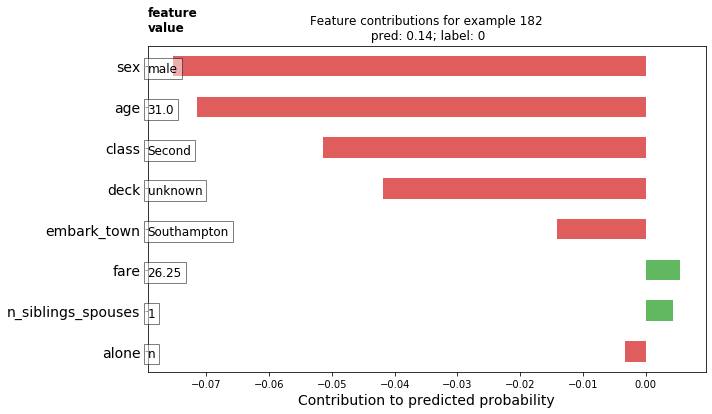

In [13]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

You can also plot the example's DFCs compare with the entire distribution using a voilin plot.

In [14]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

Plot this example.

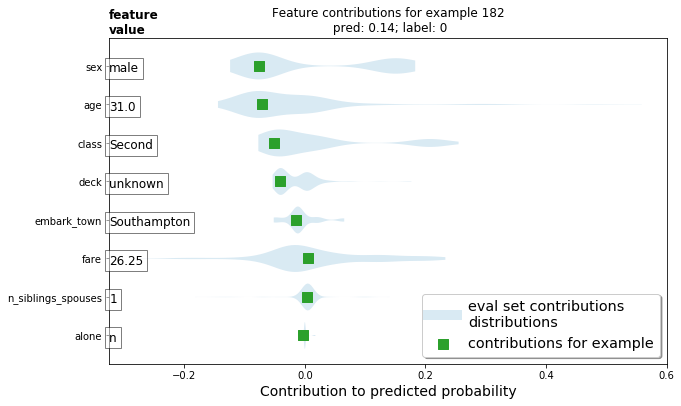

In [15]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

Finally, third-party tools, such as [LIME](https://github.com/marcotcr/lime) and [shap](https://github.com/slundberg/shap), can also help understand individual predictions for a model.

## Global feature importances

Additionally, you might want to understand the model as a whole, rather than studying individual predictions. Below, you will compute and use:

* Gain-based feature importances using `est.experimental_feature_importances`
* Permutation importances
* Aggregate DFCs using `est.experimental_predict_with_explanations`

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated ([source](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)). Check out [this article](http://explained.ai/rf-importance/index.html) for an in-depth overview and great discussion on different feature importance types.

### Gain-based feature importances

Gain-based feature importances are built into the TensorFlow Boosted Trees estimators using `est.experimental_feature_importances`.

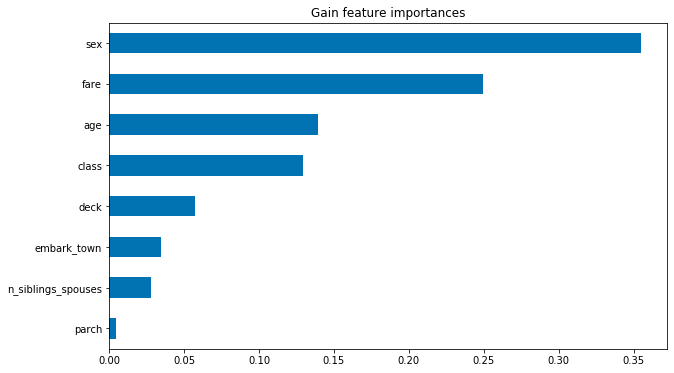

In [16]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

### Average absolute DFCs
You can also average the absolute values of DFCs to understand impact at a global level.

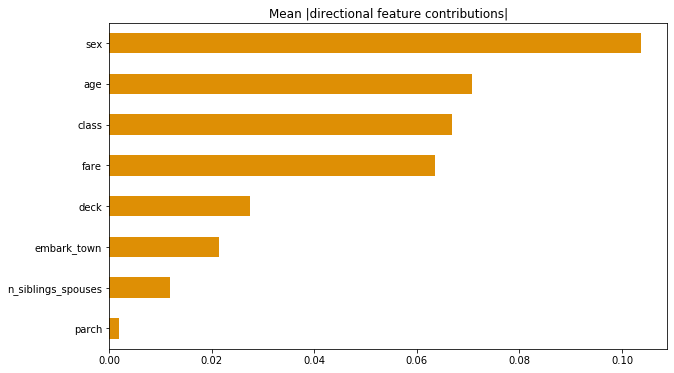

In [17]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

You can also see how DFCs vary as a feature value varies.

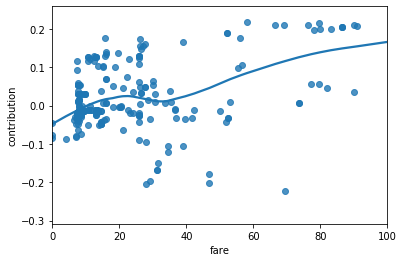

In [18]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

### Permutation feature importance

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-13T22:06:41Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from G:\TMP\tmp3dla083l\model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-01-13-22:06:42
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.8030303, accuracy_baseline = 0.625, auc = 0.8680134, auc_precision_recall = 0.85367525, average_loss = 0.4192262, global_step = 153, label/mean = 0.375, loss = 0.4192262, precision = 0.7473684, prediction/mean = 0.3857634, recall = 0.7171717
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: G:\TMP\tmp3dla083l\model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-13T22:06:43Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramete

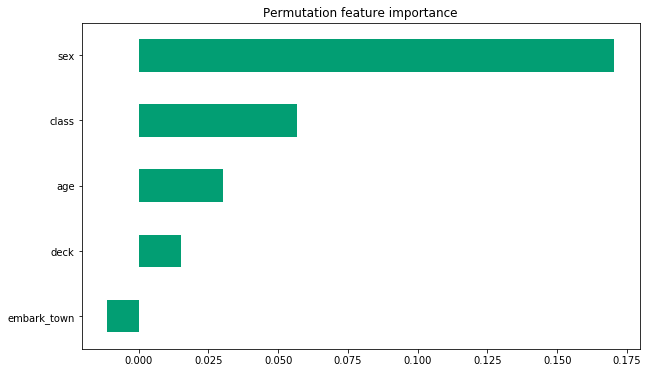

In [19]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

## Visualizing model fitting

Lets first simulate/create training data using the following formula:


$$z=x* e^{-x^2 - y^2}$$


Where \(z\) is the dependent variable you are trying to predict and \(x\) and \(y\) are the features.

In [20]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)

In [21]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [31]:
def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(111)
  # Contour the gridded data, plotting dots at the nonuniform data points.
  plt.contour(x, y, z, 15, linewidths=1.0, colors='k')
  CS = ax1.pcolormesh(x,y,z, cmap='RdBu_r')
  pp = fig.colorbar(CS, ax=ax1, orientation="vertical")

  pp.set_clim(-0.48, 0.48)
  # Plot data points.
  ax1.set_xlim(-2, 2)
  ax1.set_ylim(-2, 2)

You can visualize the function. Redder colors correspond to larger function values.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  # Remove the CWD from sys.path while we load stuff.


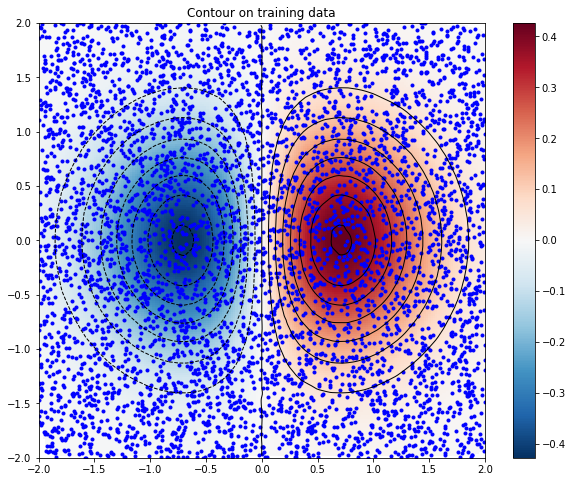

In [32]:
zi = griddata((x, y), z, (xi, yi), method='linear')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, color='b', marker='.')
plt.title('Contour on training data')
plt.show()

In [24]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [25]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

First let's try to fit a linear model to the data.

In [26]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'G:\\TMP\\tmpo10j1b2h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F0D7D9C648>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions f

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from G:\TMP\tmpo10j1b2h\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  # Remove the CWD from sys.path while we load stuff.


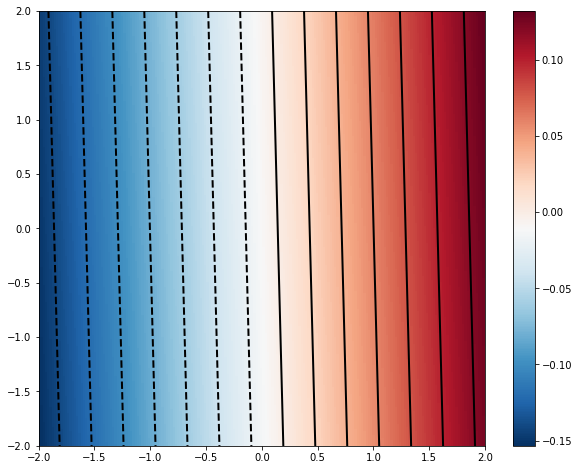

In [27]:
plot_contour(xi, yi, predict(est))

It's not a very good fit. Next let's try to fit a GBDT model to it and try to understand how the model fits the function.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from G:\TMP\tmpbkkenhur\model.ckpt-132
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  # Remove the CWD from sys.path while we load stuff.


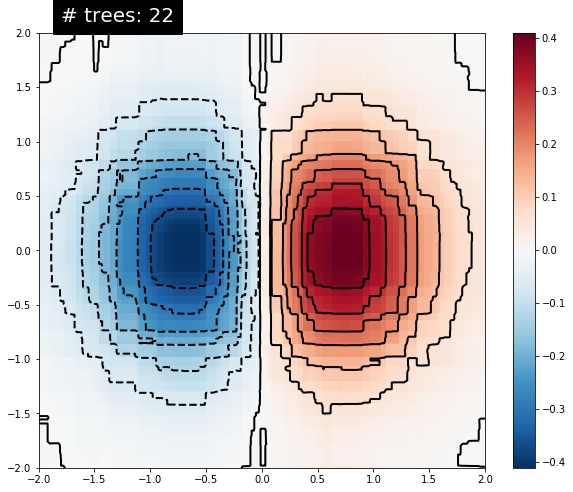

In [28]:
n_trees = 22 #@param {type: "slider", min: 1, max: 80, step: 1}

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()

As you increase the number of trees, the model's predictions better approximates the underlying function.

![](https://www.tensorflow.org/images/boosted_trees/boosted_trees_ntrees.gif)

## Conclusion

In this tutorial you learned how to interpret Boosted Trees models using directional feature contributions and feature importance techniques. These techniques provide insight into how the features impact a model's predictions. Finally, you also gained intution for how a Boosted Tree model fits a complex function by viewing the decision surface for several models.